<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/vgg16_spot/spot_postion_60epochs_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1050 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Epoch 1/60
65/65 [==============================] - 22s 294ms/step - loss: 5.2897 - accuracy: 0.3733 - val_loss: 3.3444 - val_accuracy: 0.3527
Epoch 2/60
65/65 [==============================] - 20s 307ms/step - loss: 3.4894 - accuracy: 0.3395 - val_loss: 3.1528 - val_accuracy: 0.3482
Epoch 3/60
65/65 [==============================] - 19s 293ms/step - loss: 3.0395 - accuracy: 0.3743 - val_loss: 2.8578 - val_accuracy: 0.3705
Epoch 4/60
65/65 [==============================] - 21s 319ms/step - loss: 2.9618 - accuracy: 0.3752 - val_loss: 2.5746 - val_accuracy: 0.4018
Epoch 5/60
65/65 [==============================] - 20s 301ms/step - loss: 2.5858 - accuracy: 0.4188 - val_loss: 2.4592 - val_accuracy: 0.4241
Epoch 6/60
65/65 [==============================] - 21s 318ms/step - loss: 2.4827 - accuracy: 0.4255 - val_loss: 2.2138 - val_accuracy: 0.4464
Epoch 7/60
65/65 [

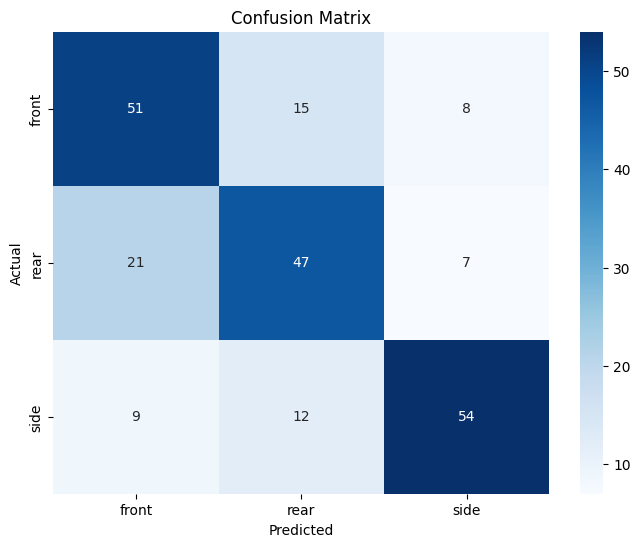

Test loss: 1.0160
Test accuracy: 67.86
Train loss: 0.6268
Train accuracy: 77.98
Recall: 0.68
Precision: 0.68
F1-score: 0.68


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/dataset for spot/train'
val_dir = '/content/drive/MyDrive/dataset for spot/validation'
test_dir = '/content/drive/MyDrive/dataset for spot/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16

# Create data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a dense layer for classification
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(3, activation='softmax')(x)  # Assuming 2 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=60,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_VGG16_epoch_60_dataset.h5')
